In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Data Preparation and Cleaning

In [2]:
df_train = pd.read_csv("./Data/npf_train.csv")
df_test = pd.read_csv("./Data/npf-test.csv")

In [3]:
def data_cleaner(df):
    data = df.copy()
    #remove the id, partlybad columns
    data.drop(["id","partlybad","date"],1,inplace=True)
    #add binary 'class2' col for event/non-event
    data["class2"] = np.where(data["class4"] == "nonevent", "nonevent","event")
    #arrange to put class2 col at the front
    cols = ['class2'] + [col for col in data if col != 'class2']
    data = data[cols]
    return data
df_train = data_cleaner(df_train)
df_test = data_cleaner(df_test)
df_train

/var/folders/1r/vj3w2rcx0gx3s0pc167jw_xr0000gn/T/ipykernel_32862/4207997387.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(["id","partlybad","date"],1,inplace=True)
/var/folders/1r/vj3w2rcx0gx3s0pc167jw_xr0000gn/T/ipykernel_32862/4207997387.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(["id","partlybad","date"],1,inplace=True)


,class2,class4,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,event,Ib,368.771711,0.310309,368.665658,0.305127,369.371184,0.333606,368.616053,0.302364,...,-1.476016,0.250952,-0.899393,0.271648,2.492491,1.310880,0.031587,0.018122,0.000243,0.000035
1,nonevent,nonevent,378.197295,1.001493,378.083089,1.025472,378.671311,1.017208,378.029508,1.022258,...,1.479493,0.313460,2.033191,0.271090,0.295937,0.177836,0.005140,0.003552,0.003658,0.000940
2,event,Ib,373.043158,0.749865,372.930066,0.728411,373.569735,0.835240,372.869868,0.692828,...,-0.270844,2.037111,0.780422,2.334741,14.434789,8.627312,0.353743,0.272472,0.000591,0.000191
3,event,II,375.643019,0.558629,375.549430,0.540964,376.045849,0.580730,375.506013,0.529970,...,5.622308,2.509758,6.533544,2.695277,16.077513,9.984686,0.568242,0.451830,0.002493,0.000466
4,nonevent,nonevent,377.661030,0.408421,377.609576,0.423963,378.117134,0.417243,377.582242,0.424460,...,1.140121,1.438071,2.133774,1.614122,9.710422,7.054069,0.339135,0.291457,0.004715,0.000679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,nonevent,nonevent,381.016623,4.411571,381.030844,4.062115,382.901742,5.061991,381.072078,3.840630,...,16.319361,1.089563,17.268471,1.308728,8.688739,8.320799,0.464422,0.496816,0.002423,0.000425
460,nonevent,nonevent,383.698146,8.418351,384.052632,8.130389,386.436800,9.901536,384.105592,7.952936,...,15.820245,2.868514,16.352391,3.055122,18.475262,12.838481,0.884404,0.726461,0.002476,0.000902
461,nonevent,nonevent,379.279128,12.045785,379.363087,11.533353,381.268591,14.043508,379.163200,10.932955,...,14.421092,1.696894,15.094141,1.745526,8.099394,5.851942,0.416961,0.363890,0.003484,0.000457
462,nonevent,nonevent,384.443758,6.413297,384.364392,5.781036,386.384762,7.663215,384.186892,5.506259,...,15.049728,0.969001,16.076217,1.197644,11.665070,10.062797,0.622831,0.595032,0.004782,0.001082


In [4]:
df_train_binary = df_train.drop("class4",axis = 1)
df_train_binary.replace(to_replace=["event","nonevent"],value=[1,0],inplace=True)

# Feature Selection

1. Remove featrues who are not relevant to label.

<AxesSubplot:>

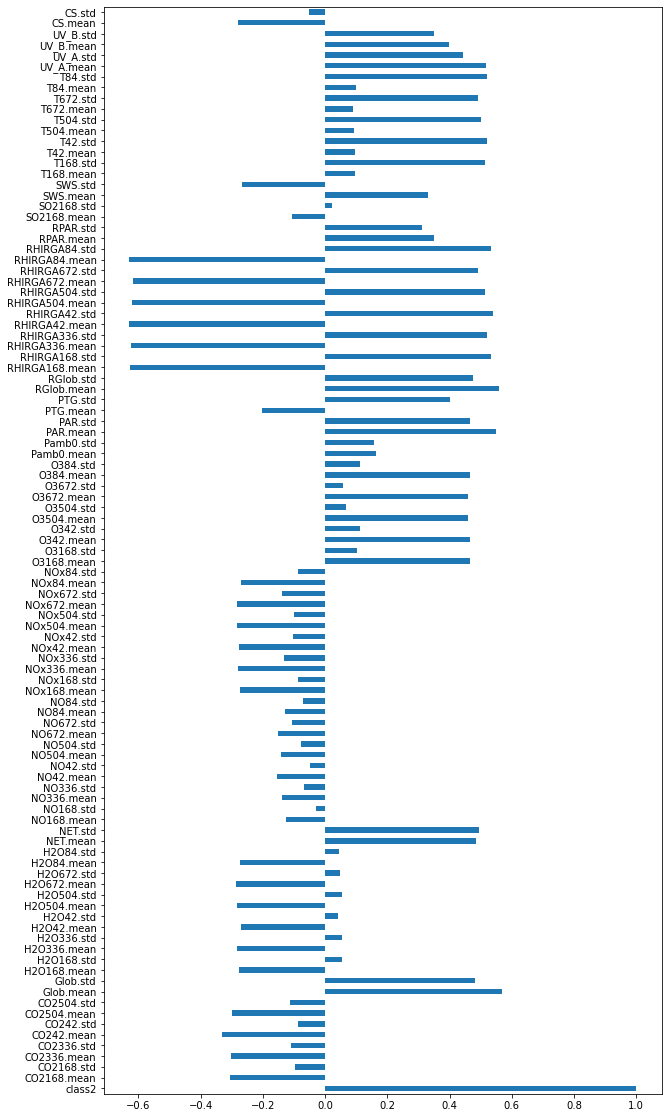

In [5]:
df_train_binary =  df_train_binary[df_train_binary.columns].apply(lambda x:x.astype(float))
(df_train_binary.corr().loc['class2'] 
 .plot(kind='barh', figsize=(10,20)))


<AxesSubplot:>

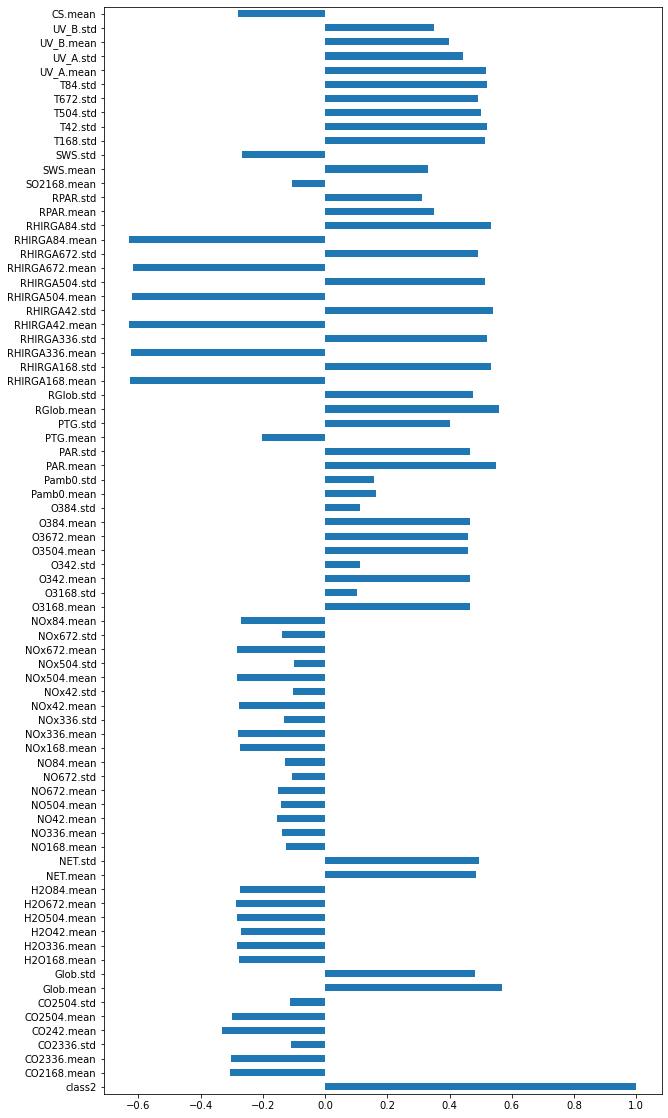

In [6]:
corr = abs(df_train_binary.corr().loc['class2']) 
corr = corr[corr<=0.1] 
cols_to_drop = corr.index.to_list() 
df_train_binary = df_train_binary.drop(cols_to_drop, axis=1)
(df_train_binary.corr().loc['class2'] 
 .plot(kind='barh', figsize=(10,20)))

In [7]:
def get_var_no_colinear(cutoff, df):
    corr_high = df.corr().applymap(lambda x: np.nan if x>cutoff else x).isnull()
    col_all = corr_high.columns.tolist()
    del_col = []
    i = 0
    while i < len(col_all)-1:
        ex_index = corr_high.iloc[:,i][i+1:].index[np.where(corr_high.iloc[:,i][i+1:])].tolist()
        for var in ex_index:
            col_all.remove(var)
        corr_high = corr_high.loc[col_all, col_all]
        i += 1
    return col_all

In [8]:
df_train_binary = pd.DataFrame(df_train_binary,columns = get_var_no_colinear(0.98,df_train_binary))
df_train_binary

,class2,CO2168.mean,CO2336.std,Glob.mean,Glob.std,H2O168.mean,NET.mean,NO168.mean,NO42.mean,NO672.mean,...,RHIRGA672.std,RPAR.mean,RPAR.std,SO2168.mean,SWS.mean,SWS.std,T168.std,T672.std,UV_B.mean,CS.mean
0,1.0,368.771711,0.305127,41.650106,29.942679,4.383158,-18.904776,0.015658,0.009342,0.010000,...,3.124422,4.437546,3.710280,0.114474,937.880000,0.600000,0.260461,0.250952,0.031587,0.000243
1,0.0,378.197295,1.025472,3.478842,2.165706,7.233852,16.909002,0.069672,0.056148,0.079508,...,0.977253,3.755908,2.801478,0.301803,936.000000,0.707107,0.279675,0.313460,0.005140,0.003658
2,1.0,373.043158,0.728411,297.954063,188.348344,3.575000,146.523400,0.037829,0.032450,0.036821,...,13.751257,36.968879,23.779696,0.116250,923.745098,2.161880,2.226999,2.037111,0.353743,0.000591
3,1.0,375.643019,0.540964,324.318386,193.207278,6.500566,191.957743,0.127547,0.116541,0.136329,...,8.926948,41.155687,25.166374,0.316289,925.622642,1.389887,2.650631,2.509758,0.568242,0.002493
4,0.0,377.661030,0.423963,167.479964,135.294894,6.223576,120.876883,0.144303,0.103537,0.146909,...,8.175362,23.190158,18.147788,0.692000,921.727273,2.578074,1.551858,1.438071,0.339135,0.004715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,0.0,381.016623,4.062115,121.227780,131.474300,15.121299,112.010483,0.022201,0.021250,0.027673,...,5.430262,7.864272,8.128171,0.163403,915.250000,1.902379,1.233771,1.089563,0.464422,0.002423
460,0.0,383.698146,8.130389,332.744478,243.722645,10.946556,233.307016,0.057613,0.040516,0.056667,...,17.434294,30.378113,20.920857,0.118561,890.500000,9.394365,2.949354,2.868514,0.884404,0.002476
461,0.0,379.279128,11.533353,114.298822,99.583613,13.131946,78.339978,0.049675,0.037922,0.051688,...,6.535173,8.108832,6.346370,0.077373,879.032258,21.784314,1.750257,1.696894,0.416961,0.003484
462,0.0,384.443758,5.781036,180.454576,181.538036,13.616242,136.129920,0.047338,0.040000,0.059412,...,6.732198,12.257337,12.242396,0.234548,883.048387,5.289728,1.110904,0.969001,0.622831,0.004782


In [9]:
x_binary_train = df_train_binary.iloc[:,1:38]
y_binary_train = df_train_binary["class2"]
x_binary_test = pd.DataFrame(df_test,columns=x_binary_train.columns)
y_binary_test = df_test["class2"]
y_binary_test.replace(to_replace=["event"], value=1., inplace=True)
y_binary_test.replace(to_replace=["nonevent"], value=0., inplace=True)

# Normalization

In [10]:
sc = StandardScaler().fit(x_binary_train)
x_df2 = sc.transform(x_binary_train)
x_df2 = pd.DataFrame(x_df2,columns = x_binary_train.columns)
test_x1 = sc.transform(x_binary_test)
test_x1 = pd.DataFrame(test_x1,columns = x_binary_test.columns)

# Binary Classification

In [11]:
gnb = GaussianNB().fit(x_df2,y_binary_train)
bnb = BernoulliNB().fit(x_df2,y_binary_train)
models = [gnb,bnb]

tra = []
tea = []
cva = []

nb_result = pd.DataFrame(columns=["Training-accuracy","Testing-accuracy","10-CV-accuracy"],index=["GaussianNB","BernoulliNB"])
for i in range(2):
    training_a = accuracy_score(y_binary_train,models[i].predict(x_df2))
    test_a = accuracy_score(y_binary_test,models[i].predict(test_x1))
    cv_a = np.mean(cross_val_score(models[i],x_df2,y_binary_train,cv = 10))
    tra.append(training_a)
    tea.append(test_a)
    cva.append(cv_a)
nb_result["Training-accuracy"] = tra
nb_result["Testing-accuracy"] = tea
nb_result["10-CV-accuracy"] = cva
nb_result

,Training-accuracy,Testing-accuracy,10-CV-accuracy
GaussianNB,0.799569,0.796891,0.776364
BernoulliNB,0.775862,0.789637,0.773728


# Multiclass Classification

In [12]:
y_multi_train = df_train["class4"]
y_multi_test = df_test["class4"]

In [13]:
gnb = GaussianNB().fit(x_df2,y_multi_train)
bnb = BernoulliNB().fit(x_df2,y_multi_train)
models = [gnb,bnb]

tra = []
tea = []
cva = []

nb_result = pd.DataFrame(columns=["Training-accuracy","Testing-accuracy","10-CV-accuracy"],index=["GaussianNB","BernoulliNB"])
for i in range(2):
    training_a = accuracy_score(y_multi_train,models[i].predict(x_df2))
    test_a = accuracy_score(y_multi_test,models[i].predict(test_x1))
    cv_a = np.mean(cross_val_score(models[i],x_df2,y_multi_train,cv = 10))
    tra.append(training_a)
    tea.append(test_a)
    cva.append(cv_a)
nb_result["Training-accuracy"] = tra
nb_result["Testing-accuracy"] = tea
nb_result["10-CV-accuracy"] = cva
nb_result

,Training-accuracy,Testing-accuracy,10-CV-accuracy
GaussianNB,0.564655,0.565803,0.483117
BernoulliNB,0.584052,0.597927,0.553700


In [16]:
result = bnb.predict(test_x1)
accuracy_score(y_multi_test,result)

0.5979274611398964

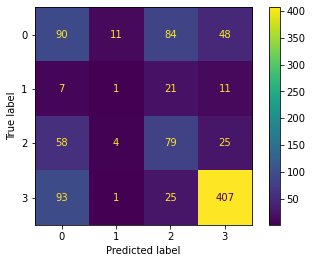

In [15]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_multi_test,result)
cm_display = ConfusionMatrixDisplay(cm).plot()